In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

import lightgbm as lgb

import xgboost as xgb
from xgboost import XGBRegressor

import catboost as cat
from catboost import CatBoostRegressor, cv, Pool


from feature_engine.categorical_encoders import CountFrequencyCategoricalEncoder
from feature_engine.outlier_removers import Winsorizer

# for Q-Q plots
import scipy.stats as stats

pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns',50)

import warnings
warnings.filterwarnings("ignore")

In [2]:
trainset = pd.read_csv('trainscaled.csv')

In [3]:
trainset.shape

(1562, 40)

In [4]:
trainset.head()

,population,renter_occupied_households,pct_renter_occupied,evictions,rent_burden,pct_white,pct_af_am,pct_hispanic,pct_am_ind,pct_asian,pct_nh_pi,pct_multiple,pct_other,poverty_rate,pct_civilian_labor,pct_unemployment,pct_uninsured_adults,pct_uninsured_children,pct_adult_obesity,pct_adult_smoking,pct_diabetes,pct_low_birthweight,pct_excessive_drinking,pct_physical_inactivity,air_pollution_particulate_matter_value,homicides_per_100k,motor_vehicle_crash_deaths_per_100k,heart_disease_mortality_per_100k,pop_per_dentist,pop_per_primary_care_physician,pct_female,pct_below_18_years_of_age,pct_aged_65_years_and_older,pct_adults_less_than_a_high_school_diploma,pct_adults_with_high_school_diploma,pct_adults_with_some_college,pct_adults_bachelors_or_higher,birth_rate_per_1k,death_rate_per_1k,gross_rent
0,0.023278,0.018812,0.420128,0.404262,0.030726,0.936146,0.043597,0.127406,0.421113,0.215669,0.0,0.154963,0.000000,0.163225,0.722222,0.100917,0.153627,0.266062,0.515625,0.344697,0.442227,0.533640,1.000000,0.733696,0.489973,0.0,0.470317,0.323718,0.465234,0.501390,0.000000,0.440789,0.620098,0.207955,0.452178,0.813736,0.415881,0.374501,0.453269,577.0
1,0.064244,0.060264,0.519494,0.004059,0.412926,0.758344,0.009255,0.848575,0.133586,0.057134,0.0,0.314188,0.000000,0.301803,0.708333,0.256881,0.770982,1.000000,0.218750,0.102273,0.156513,0.375000,0.743421,0.030797,0.346224,0.0,0.382833,0.208333,0.251953,0.317346,0.015625,0.914474,0.066176,0.259255,0.120183,0.495366,1.000000,0.756832,0.000000,844.0
2,0.172656,0.156567,0.342441,0.010147,0.612163,0.950002,0.020827,0.064041,0.350227,0.180185,0.0,0.386648,0.302571,0.382985,0.605556,0.467890,0.216216,0.084656,0.442708,0.530303,0.332983,0.375000,0.657895,0.429348,0.488508,0.0,0.425370,0.378205,0.650640,0.240877,0.390625,0.375000,0.629902,0.384272,0.608543,0.323791,0.477163,0.341289,0.530341,700.0
3,0.054635,0.053319,0.381232,0.001015,0.460735,0.869808,0.001209,0.374684,0.073682,0.164462,0.0,0.600487,0.000000,0.537368,0.708333,0.238532,0.438122,0.399093,0.229167,0.405303,0.475840,0.505952,0.539474,0.487319,0.724182,0.0,0.687935,0.368590,0.615919,0.330616,0.500000,0.276316,0.742647,0.188226,0.401060,0.849031,0.464484,0.321025,0.530151,592.0
4,0.022019,0.016461,0.351525,0.003044,0.090166,0.907514,0.002010,0.209854,0.000000,0.521310,0.0,0.441397,0.736020,0.321482,0.511111,0.201835,0.352774,0.344671,0.588542,0.162879,0.551471,0.533640,0.598684,0.726449,0.559720,0.0,0.470317,0.493590,0.465234,0.218161,0.703125,0.467105,0.816176,0.238016,0.542461,0.656507,0.414058,0.334704,0.795009,444.0


In [5]:
trainset.describe()

,population,renter_occupied_households,pct_renter_occupied,evictions,rent_burden,pct_white,pct_af_am,pct_hispanic,pct_am_ind,pct_asian,pct_nh_pi,pct_multiple,pct_other,poverty_rate,pct_civilian_labor,pct_unemployment,pct_uninsured_adults,pct_uninsured_children,pct_adult_obesity,pct_adult_smoking,pct_diabetes,pct_low_birthweight,pct_excessive_drinking,pct_physical_inactivity,air_pollution_particulate_matter_value,homicides_per_100k,motor_vehicle_crash_deaths_per_100k,heart_disease_mortality_per_100k,pop_per_dentist,pop_per_primary_care_physician,pct_female,pct_below_18_years_of_age,pct_aged_65_years_and_older,pct_adults_less_than_a_high_school_diploma,pct_adults_with_high_school_diploma,pct_adults_with_some_college,pct_adults_bachelors_or_higher,birth_rate_per_1k,death_rate_per_1k,gross_rent
count,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.0,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000
mean,0.315221,0.307278,0.518656,0.222805,0.496731,0.708599,0.272241,0.326421,0.332073,0.325477,0.270126,0.419322,0.252045,0.470485,0.499908,0.460830,0.474128,0.422454,0.489837,0.511937,0.497184,0.524037,0.504780,0.498382,0.568918,0.0,0.462673,0.510112,0.430859,0.450058,0.483813,0.506787,0.507084,0.407839,0.501116,0.498353,0.420082,0.505318,0.498212,690.869398
std,0.337841,0.343665,0.196259,0.284466,0.202335,0.257653,0.349887,0.319087,0.332592,0.322053,0.376301,0.241998,0.319427,0.206988,0.187070,0.195608,0.188293,0.232360,0.213047,0.205725,0.187619,0.216655,0.248111,0.190813,0.195846,0.0,0.228129,0.181536,0.247532,0.249586,0.224884,0.208049,0.205118,0.211113,0.185760,0.189060,0.244388,0.209528,0.187483,161.102958
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,351.000000
25%,0.065720,0.055466,0.375000,0.007103,0.375000,0.551980,0.022375,0.091731,0.088988,0.091503,0.000000,0.247124,0.000000,0.312640,0.375000,0.311927,0.338549,0.247921,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.415497,0.0,0.298645,0.375000,0.238404,0.258645,0.375000,0.375000,0.375000,0.243483,0.379902,0.375000,0.239495,0.375000,0.375000,578.000000
50%,0.161420,0.147106,0.489220,0.074579,0.508269,0.807125,0.083452,0.184039,0.193323,0.202047,0.000000,0.376976,0.101029,0.437152,0.501389,0.449541,0.463727,0.368859,0.494792,0.517733,0.484244,0.494048,0.511962,0.512681,0.600624,0.0,0.470317,0.493590,0.384874,0.405060,0.515625,0.500000,0.495098,0.357291,0.516032,0.499035,0.362974,0.496403,0.497575,650.000000
75%,0.439432,0.433279,0.625000,0.404262,0.625000,0.919966,0.413425,0.455039,0.453393,0.454902,0.400000,0.548274,0.400000,0.587584,0.625000,0.587156,0.603129,0.548753,0.625000,0.625000,0.625000,0.625000,0.625000,0.625000,0.728557,0.0,0.579187,0.625000,0.543043,0.555187,0.625000,0.625000,0.625000,0.546090,0.633171,0.625000,0.543697,0.625000,0.625000,773.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1067.375000


In [6]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1562 entries, 0 to 1561
Data columns (total 40 columns):
population                                    1562 non-null float64
renter_occupied_households                    1562 non-null float64
pct_renter_occupied                           1562 non-null float64
evictions                                     1562 non-null float64
rent_burden                                   1562 non-null float64
pct_white                                     1562 non-null float64
pct_af_am                                     1562 non-null float64
pct_hispanic                                  1562 non-null float64
pct_am_ind                                    1562 non-null float64
pct_asian                                     1562 non-null float64
pct_nh_pi                                     1562 non-null float64
pct_multiple                                  1562 non-null float64
pct_other                                     1562 non-null float64
poverty_r

In [7]:
X_num = trainset.iloc[:,0:39]
y_num = trainset.iloc[:,39]

In [8]:
X_num.shape

(1562, 39)

In [9]:
y_num.shape

(1562,)

In [10]:
X_num.head()

,population,renter_occupied_households,pct_renter_occupied,evictions,rent_burden,pct_white,pct_af_am,pct_hispanic,pct_am_ind,pct_asian,pct_nh_pi,pct_multiple,pct_other,poverty_rate,pct_civilian_labor,pct_unemployment,pct_uninsured_adults,pct_uninsured_children,pct_adult_obesity,pct_adult_smoking,pct_diabetes,pct_low_birthweight,pct_excessive_drinking,pct_physical_inactivity,air_pollution_particulate_matter_value,homicides_per_100k,motor_vehicle_crash_deaths_per_100k,heart_disease_mortality_per_100k,pop_per_dentist,pop_per_primary_care_physician,pct_female,pct_below_18_years_of_age,pct_aged_65_years_and_older,pct_adults_less_than_a_high_school_diploma,pct_adults_with_high_school_diploma,pct_adults_with_some_college,pct_adults_bachelors_or_higher,birth_rate_per_1k,death_rate_per_1k
0,0.023278,0.018812,0.420128,0.404262,0.030726,0.936146,0.043597,0.127406,0.421113,0.215669,0.0,0.154963,0.000000,0.163225,0.722222,0.100917,0.153627,0.266062,0.515625,0.344697,0.442227,0.533640,1.000000,0.733696,0.489973,0.0,0.470317,0.323718,0.465234,0.501390,0.000000,0.440789,0.620098,0.207955,0.452178,0.813736,0.415881,0.374501,0.453269
1,0.064244,0.060264,0.519494,0.004059,0.412926,0.758344,0.009255,0.848575,0.133586,0.057134,0.0,0.314188,0.000000,0.301803,0.708333,0.256881,0.770982,1.000000,0.218750,0.102273,0.156513,0.375000,0.743421,0.030797,0.346224,0.0,0.382833,0.208333,0.251953,0.317346,0.015625,0.914474,0.066176,0.259255,0.120183,0.495366,1.000000,0.756832,0.000000
2,0.172656,0.156567,0.342441,0.010147,0.612163,0.950002,0.020827,0.064041,0.350227,0.180185,0.0,0.386648,0.302571,0.382985,0.605556,0.467890,0.216216,0.084656,0.442708,0.530303,0.332983,0.375000,0.657895,0.429348,0.488508,0.0,0.425370,0.378205,0.650640,0.240877,0.390625,0.375000,0.629902,0.384272,0.608543,0.323791,0.477163,0.341289,0.530341
3,0.054635,0.053319,0.381232,0.001015,0.460735,0.869808,0.001209,0.374684,0.073682,0.164462,0.0,0.600487,0.000000,0.537368,0.708333,0.238532,0.438122,0.399093,0.229167,0.405303,0.475840,0.505952,0.539474,0.487319,0.724182,0.0,0.687935,0.368590,0.615919,0.330616,0.500000,0.276316,0.742647,0.188226,0.401060,0.849031,0.464484,0.321025,0.530151
4,0.022019,0.016461,0.351525,0.003044,0.090166,0.907514,0.002010,0.209854,0.000000,0.521310,0.0,0.441397,0.736020,0.321482,0.511111,0.201835,0.352774,0.344671,0.588542,0.162879,0.551471,0.533640,0.598684,0.726449,0.559720,0.0,0.470317,0.493590,0.465234,0.218161,0.703125,0.467105,0.816176,0.238016,0.542461,0.656507,0.414058,0.334704,0.795009


In [11]:
y_num.head()

0    577.0
1    844.0
2    700.0
3    592.0
4    444.0
Name: gross_rent, dtype: float64

### Tree Based Method Feature Selection

In [12]:
rf = RandomForestRegressor(n_estimators=100,criterion='mae',n_jobs=-1)

In [13]:
rfFit = rf.fit(X_num,y_num)

In [14]:
print(rfFit.feature_importances_)

[0.17754006 0.0155787  0.01583032 0.01125649 0.02069813 0.0179348
 0.01268035 0.02747819 0.0127317  0.05188109 0.00656803 0.02042513
 0.02165889 0.039197   0.01378384 0.01637998 0.00964865 0.01627259
 0.04699292 0.01349489 0.01226185 0.00760285 0.01044233 0.02724967
 0.01602995 0.         0.01154247 0.01548124 0.01317423 0.00995095
 0.01038941 0.0133468  0.02989725 0.0152707  0.02363689 0.01609555
 0.11590733 0.01406416 0.06962464]


In [15]:
colname = pd.DataFrame(trainset.columns, columns=['Name'])

In [16]:
colname.head()

,Name
0,population
1,renter_occupied_households
2,pct_renter_occupied
3,evictions
4,rent_burden


In [17]:
result = pd.DataFrame(rfFit.feature_importances_,columns=['result'])

In [18]:
result.head()

,result
0,0.177540
1,0.015579
2,0.015830
3,0.011256
4,0.020698


In [19]:
combined = pd.concat([colname,result],axis=1)

In [20]:
combined.sort_values(by='result')

,Name,result
25,homicides_per_100k,0.000000
10,pct_nh_pi,0.006568
21,pct_low_birthweight,0.007603
16,pct_uninsured_adults,0.009649
29,pop_per_primary_care_physician,0.009951
30,pct_female,0.010389
22,pct_excessive_drinking,0.010442
3,evictions,0.011256
26,motor_vehicle_crash_deaths_per_100k,0.011542
20,pct_diabetes,0.012262


**Significant feature = 'population', 'pct_adults_bachelors_or_higher','pct_asian','death_rate_per_1k', 
poverty_rate, pct_adult_obesity, pct_aged_65_years_and_older **

In [21]:
et = ExtraTreesRegressor(n_estimators=100,criterion='mae',n_jobs=-1)
etFit = et.fit(X_num,y_num)

In [22]:
etFit.feature_importances_

array([0.15751005, 0.05401134, 0.01808712, 0.014762  , 0.01896579,
       0.01616916, 0.0147362 , 0.02424685, 0.01314394, 0.06649364,
       0.01173797, 0.02064971, 0.02292601, 0.03456076, 0.01479578,
       0.01647502, 0.01187336, 0.01602879, 0.03138659, 0.01764242,
       0.01453803, 0.01067312, 0.01325877, 0.02891163, 0.01593255,
       0.        , 0.01221586, 0.018601  , 0.01341116, 0.0121172 ,
       0.01325596, 0.01390078, 0.02901723, 0.01489586, 0.0252056 ,
       0.01534446, 0.08232769, 0.01497919, 0.0552114 ])

In [23]:
colname = pd.DataFrame(trainset.columns, columns=['Name'])

In [24]:
colname.head()

,Name
0,population
1,renter_occupied_households
2,pct_renter_occupied
3,evictions
4,rent_burden


In [25]:
result = pd.DataFrame(etFit.feature_importances_,columns=['Result'])

In [26]:
result.head()

,Result
0,0.157510
1,0.054011
2,0.018087
3,0.014762
4,0.018966


In [27]:
combined = pd.concat([colname,result],axis=1)

In [28]:
combined.sort_values(by='Result')

,Name,Result
25,homicides_per_100k,0.000000
21,pct_low_birthweight,0.010673
10,pct_nh_pi,0.011738
16,pct_uninsured_adults,0.011873
29,pop_per_primary_care_physician,0.012117
26,motor_vehicle_crash_deaths_per_100k,0.012216
8,pct_am_ind,0.013144
30,pct_female,0.013256
22,pct_excessive_drinking,0.013259
28,pop_per_dentist,0.013411


**Significant Features = 'population', 'renter_occupied_households','poverty_rate',
'pct_adults_bachelors_or_higher','death_rate_per_1k','pct_adults_with_high_school_diploma','poverty_rate' **

### Using LightGBM

In [29]:
trainingdata = lgb.Dataset(data=X_num, label=y_num)
params = {}
params['learning_rate'] = 0.1
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = ['mean_absolute_error']

lgbmodel = lgb.train(params=params,train_set=trainingdata,num_boost_round=100)

In [30]:
lgbmodel.feature_importance()

array([135,  57,  86,  51, 146,  95,  67,  98,  70,  69,  19,  97,  56,
       189,  74,  73,  55, 102,  89,  74,  75,  25,  38,  75, 117,   0,
        50,  56,  64,  67,  47,  59,  90,  63,  70,  84, 104, 101, 113])

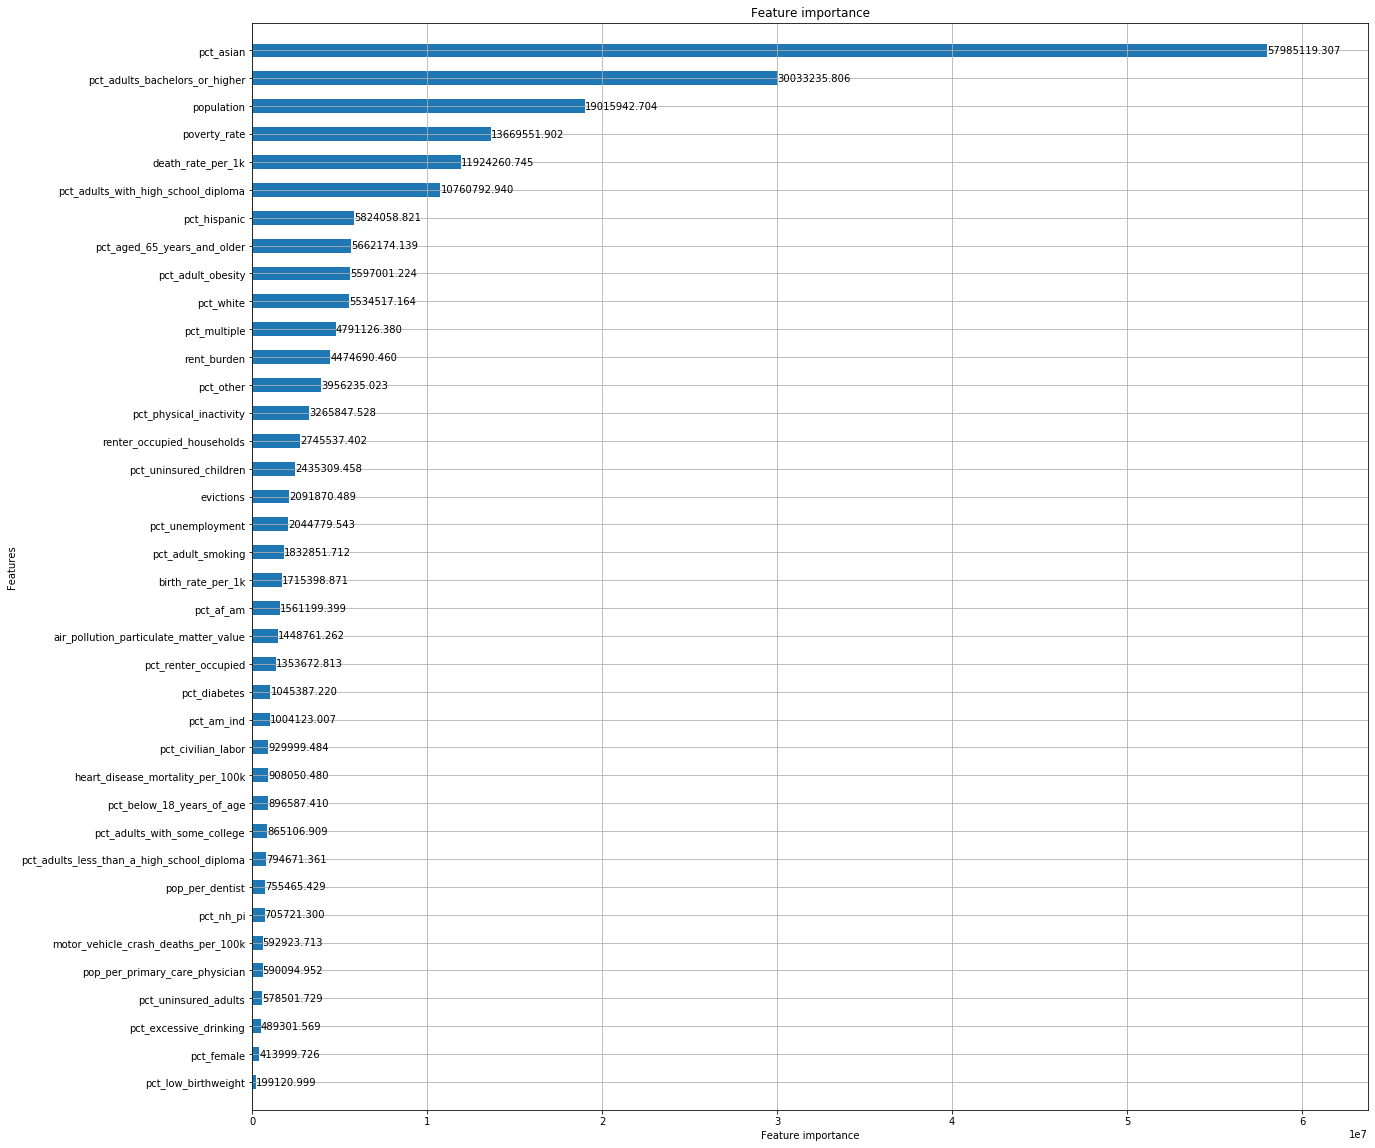

In [31]:
lgb.plot_importance(lgbmodel,height=0.5, figsize=(20,20), importance_type='gain')
plt.show()

In [32]:
colname = pd.DataFrame(trainset.columns, columns=['Name'])

In [33]:
colname.head()

,Name
0,population
1,renter_occupied_households
2,pct_renter_occupied
3,evictions
4,rent_burden


In [34]:
result = pd.DataFrame(lgbmodel.feature_importance(),columns=['Result'])

In [35]:
result.head()

,Result
0,135
1,57
2,86
3,51
4,146


In [36]:
combined = pd.concat([colname,result], axis=1)

In [37]:
combined.sort_values(by='Result')

,Name,Result
25,homicides_per_100k,0.0
10,pct_nh_pi,19.0
21,pct_low_birthweight,25.0
22,pct_excessive_drinking,38.0
30,pct_female,47.0
26,motor_vehicle_crash_deaths_per_100k,50.0
3,evictions,51.0
16,pct_uninsured_adults,55.0
27,heart_disease_mortality_per_100k,56.0
12,pct_other,56.0


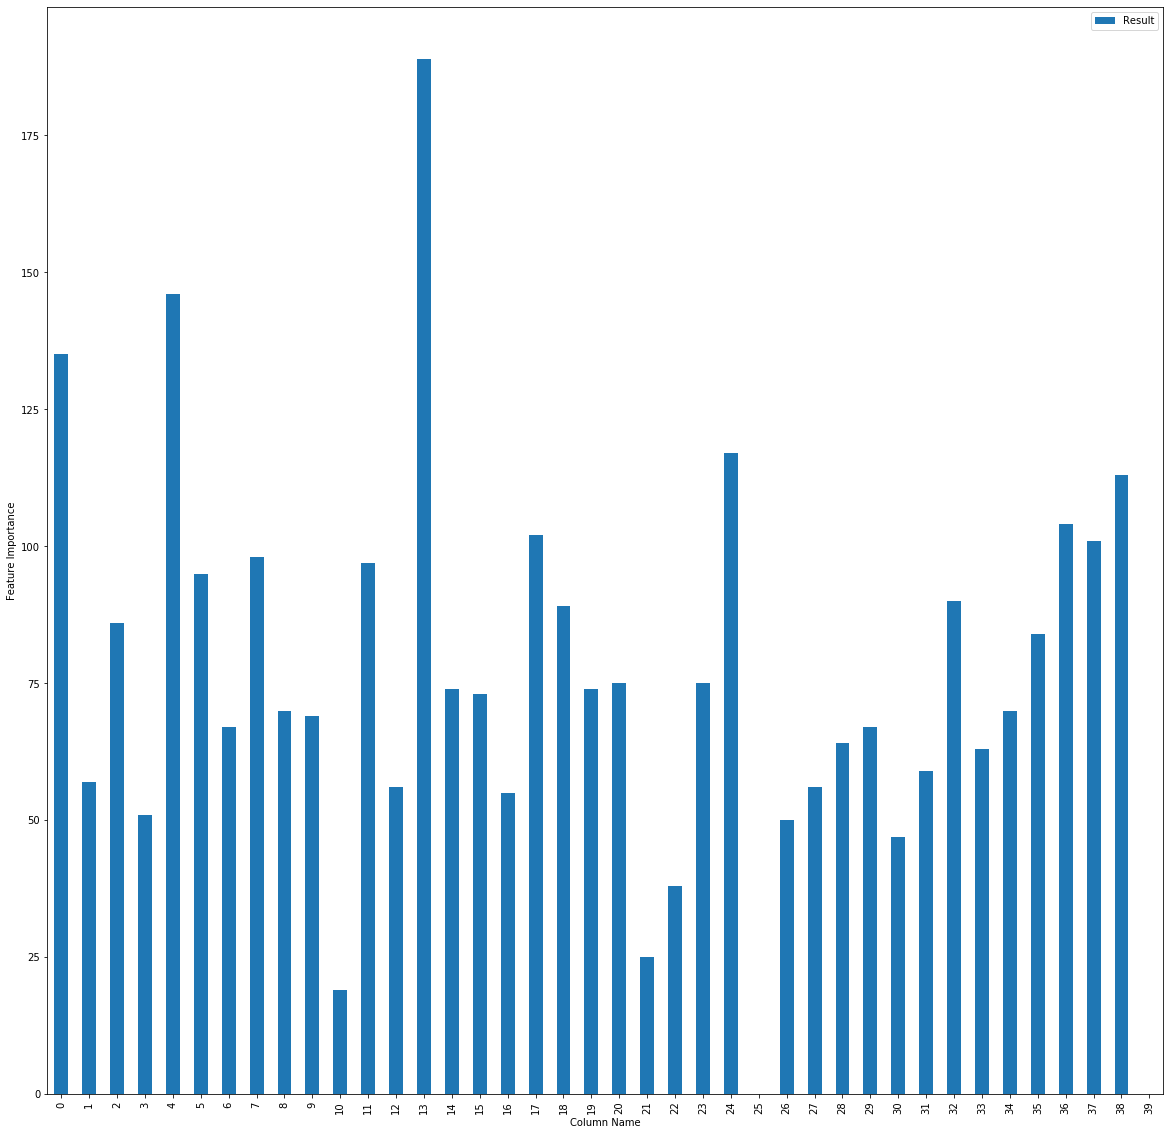

In [38]:
combined.plot(kind='bar',figsize=(20,20))
plt.xlabel("Column Name")
plt.ylabel("Feature Importance")
plt.show()

**Significant features = Please See Graph **

### Using XGBoost

In [39]:
xgbreg = xgb.XGBRegressor(objective ='reg:squarederror')
xgbreg.fit(X_num,y_num)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [40]:
print(xgbreg.feature_importances_)

[0.07696298 0.01660992 0.00386867 0.01424391 0.00868824 0.02070882
 0.00626704 0.02989123 0.0057078  0.23172656 0.01191149 0.01876272
 0.03015751 0.02051348 0.00317424 0.01905219 0.00479165 0.00715215
 0.02423142 0.00420569 0.00830371 0.00435355 0.00536007 0.02929649
 0.00589588 0.         0.00895178 0.00218779 0.00625225 0.00286753
 0.00486453 0.00283667 0.0187937  0.00682547 0.10440589 0.00490498
 0.15161568 0.00452955 0.0691267 ]


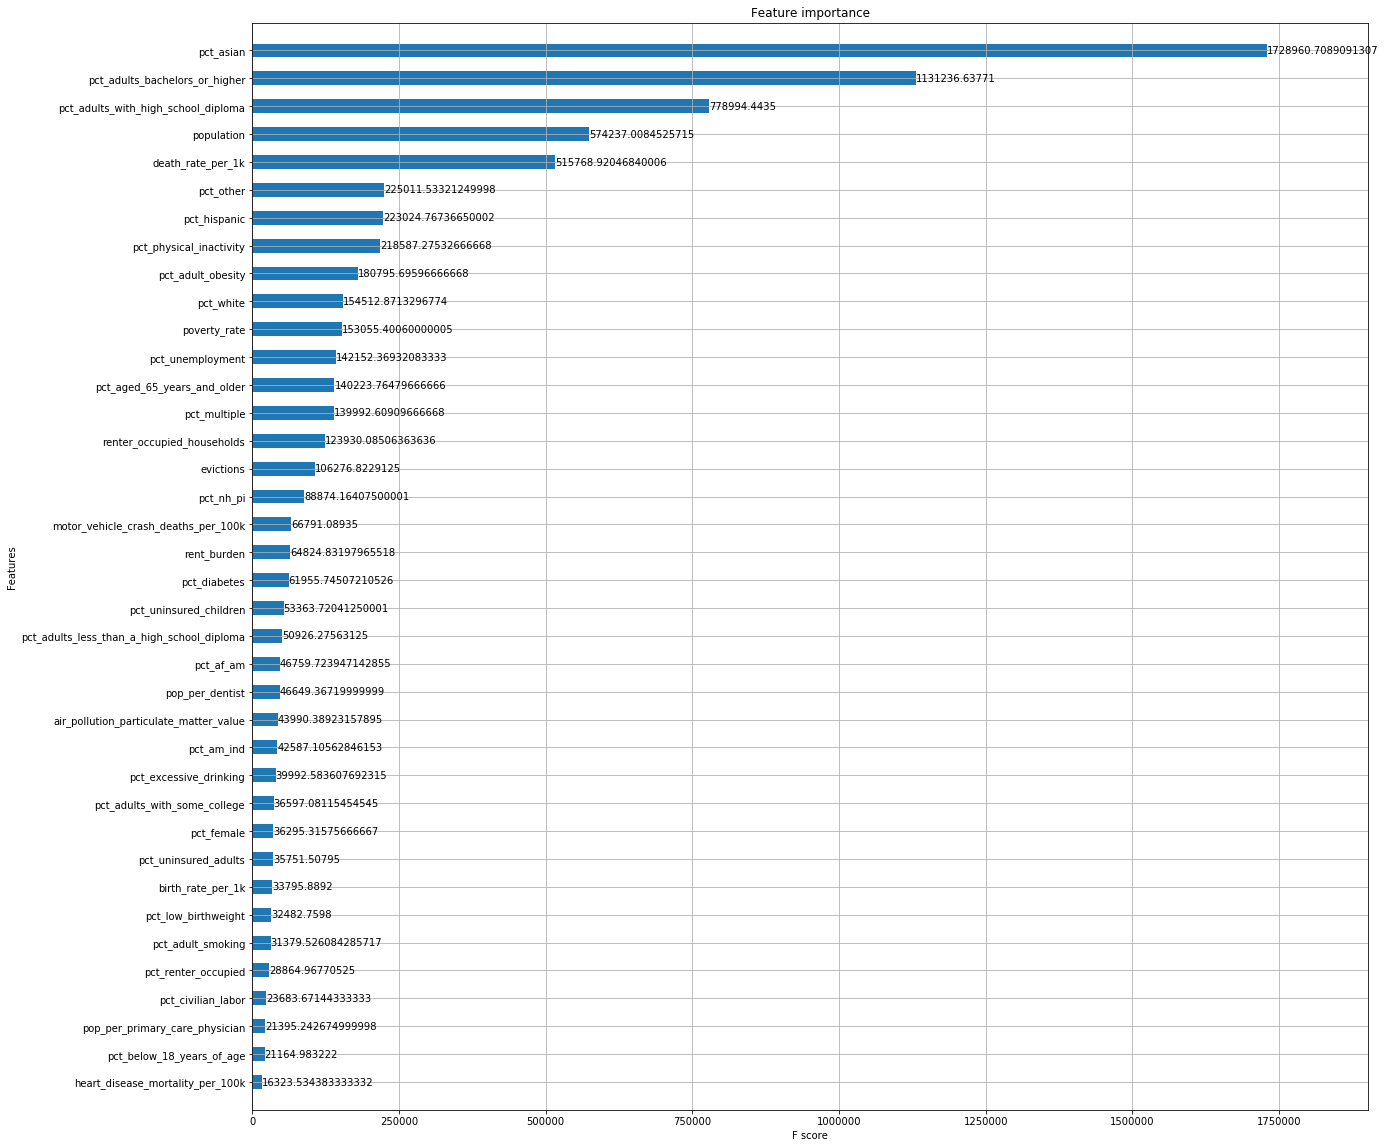

In [41]:
ax = xgb.plot_importance(xgbreg,height=0.5,importance_type='gain')
fig = ax.figure
fig.set_size_inches(20,20)

In [42]:
colname = pd.DataFrame(trainset.columns, columns=['Name'])

In [43]:
colname.head()

,Name
0,population
1,renter_occupied_households
2,pct_renter_occupied
3,evictions
4,rent_burden


In [44]:
result = pd.DataFrame(xgbreg.feature_importances_, columns=['Result'])

In [45]:
result.head()

,Result
0,0.076963
1,0.016610
2,0.003869
3,0.014244
4,0.008688


In [46]:
combined = pd.concat([colname,result], axis=1)

In [47]:
combined.sort_values(by='Result')

,Name,Result
25,homicides_per_100k,0.000000
27,heart_disease_mortality_per_100k,0.002188
31,pct_below_18_years_of_age,0.002837
29,pop_per_primary_care_physician,0.002868
14,pct_civilian_labor,0.003174
2,pct_renter_occupied,0.003869
19,pct_adult_smoking,0.004206
21,pct_low_birthweight,0.004354
37,birth_rate_per_1k,0.004530
16,pct_uninsured_adults,0.004792


**Significant Features: Please see Graph **

### Using Catboost

In [48]:
#Define a Pool Dataset
trainpool = Pool(data=X_num,label=y_num)

In [49]:
catreg = cat.CatBoostRegressor(iterations=100,loss_function='MAE')
catreg.fit(X_num,y_num)

0:	learn: 121.7098591	total: 174ms	remaining: 17.2s
1:	learn: 119.5400719	total: 184ms	remaining: 8.99s
2:	learn: 117.4076754	total: 193ms	remaining: 6.24s
3:	learn: 115.4473218	total: 202ms	remaining: 4.85s
4:	learn: 113.5598670	total: 210ms	remaining: 3.99s
5:	learn: 111.6534567	total: 219ms	remaining: 3.43s
6:	learn: 109.8545570	total: 230ms	remaining: 3.05s
7:	learn: 108.1035615	total: 237ms	remaining: 2.73s
8:	learn: 106.3330600	total: 244ms	remaining: 2.47s
9:	learn: 104.6934853	total: 252ms	remaining: 2.27s
10:	learn: 103.0402074	total: 259ms	remaining: 2.1s
11:	learn: 101.4477034	total: 266ms	remaining: 1.95s
12:	learn: 99.9702937	total: 274ms	remaining: 1.83s
13:	learn: 98.4723399	total: 286ms	remaining: 1.76s
14:	learn: 97.0377811	total: 294ms	remaining: 1.66s
15:	learn: 95.7171044	total: 301ms	remaining: 1.58s
16:	learn: 94.3814347	total: 308ms	remaining: 1.5s
17:	learn: 93.2383199	total: 316ms	remaining: 1.44s
18:	learn: 92.1417033	total: 323ms	remaining: 1.38s
19:	learn: 9

In [50]:
catreg.get_feature_importance(type='PredictionValuesChange')

array([10.3969465 ,  4.31531886,  1.00325887,  1.54726677,  2.44765352,
        4.36450245,  1.48819484,  4.01241431,  1.63897427,  4.21798552,
        1.08940648,  1.32249817,  1.90964391,  9.22290397,  1.20853162,
        2.10754418,  1.10186645,  2.16189198,  3.00797049,  0.48712483,
        1.41571618,  0.23226888,  0.38520496,  4.42077628,  1.19659693,
        0.        ,  0.3954504 ,  1.4654702 ,  1.70140343,  0.26838868,
        0.49004479,  0.28192962,  2.39619878,  1.12502102,  4.48654156,
        1.34454959,  8.63703345,  0.46206142, 10.24344586])

In [51]:
colname = pd.DataFrame(trainset.columns, columns=['Name'])

In [52]:
colname.head()

,Name
0,population
1,renter_occupied_households
2,pct_renter_occupied
3,evictions
4,rent_burden


In [53]:
result = pd.DataFrame(catreg.feature_importances_, columns=['Result'])

In [54]:
result.head()

,Result
0,10.396946
1,4.315319
2,1.003259
3,1.547267
4,2.447654


In [55]:
combined = pd.concat([colname,result], axis=1)

In [56]:
combined.sort_values(by='Result')

,Name,Result
25,homicides_per_100k,0.000000
21,pct_low_birthweight,0.232269
29,pop_per_primary_care_physician,0.268389
31,pct_below_18_years_of_age,0.281930
22,pct_excessive_drinking,0.385205
26,motor_vehicle_crash_deaths_per_100k,0.395450
37,birth_rate_per_1k,0.462061
19,pct_adult_smoking,0.487125
30,pct_female,0.490045
2,pct_renter_occupied,1.003259


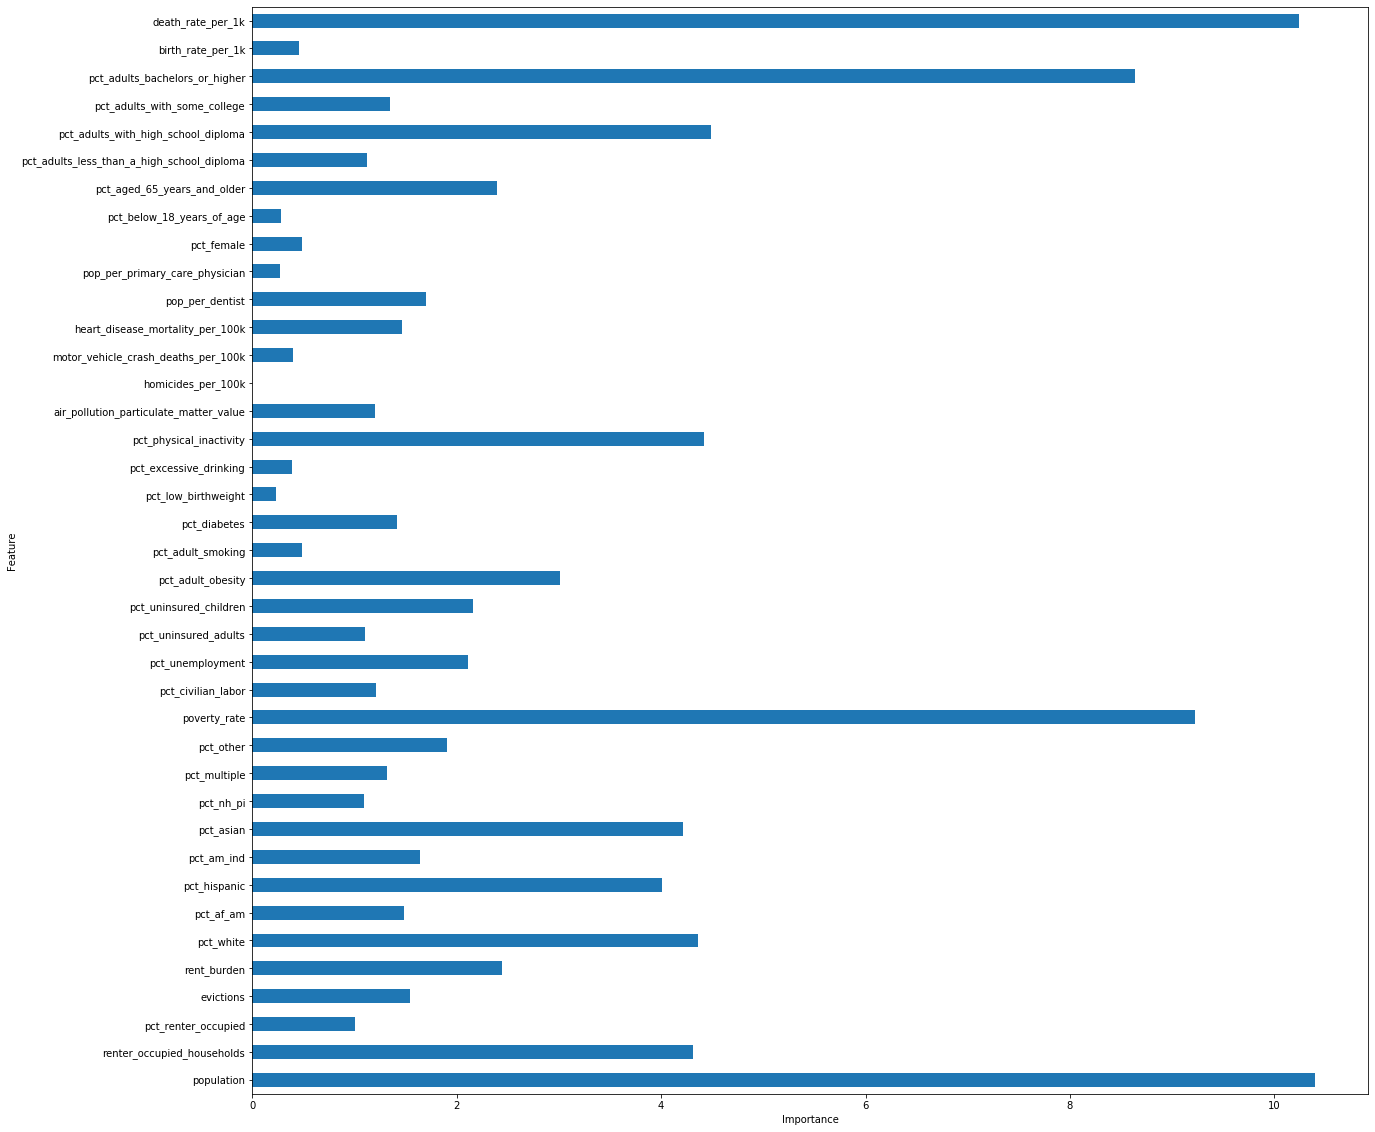

In [57]:
plt.figure(figsize=(20,20))
feat_importances = pd.Series(catreg.feature_importances_, index=X_num.columns)
feat_importances.plot(kind='barh')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

**Significant features: pct_adults_bachelors_or_higher,death_rate_per_1k, population, poverty rate, pct_hispanic,  
pct_physical_inactivity, renter_occupied_households, pct_asian **

In [58]:
catreg.get_feature_importance(data=trainpool,type='LossFunctionChange')

array([3.22876353, 1.64645101, 0.24168375, 0.73046906, 1.49257249,
       2.65933108, 0.49713749, 1.95100682, 0.32192751, 6.90454821,
       0.43277058, 0.55448455, 0.85189837, 9.49004331, 0.62188783,
       1.04104734, 0.22139941, 0.70247904, 1.51547913, 0.13550136,
       0.33182904, 0.07305215, 0.15412857, 1.82760178, 0.30097248,
       0.        , 0.18836963, 0.9375869 , 0.64290359, 0.05463597,
       0.1324827 , 0.06240828, 0.910993  , 1.24742547, 1.34982588,
       0.32444812, 3.67048209, 0.15464671, 8.03639254])

In [59]:
result2 = pd.DataFrame(catreg.get_feature_importance(data=trainpool,type='LossFunctionChange'), columns=['LossFunction'])

In [60]:
result2

,LossFunction
0,3.228764
1,1.646451
2,0.241684
3,0.730469
4,1.492572
5,2.659331
6,0.497137
7,1.951007
8,0.321928
9,6.904548


In [61]:
combined2 = pd.concat([colname,result2], axis=1)

In [62]:
combined3 = combined2.sort_values(by='LossFunction')

In [63]:
combined3

,Name,LossFunction
25,homicides_per_100k,0.000000
29,pop_per_primary_care_physician,0.054636
31,pct_below_18_years_of_age,0.062408
21,pct_low_birthweight,0.073052
30,pct_female,0.132483
19,pct_adult_smoking,0.135501
22,pct_excessive_drinking,0.154129
37,birth_rate_per_1k,0.154647
26,motor_vehicle_crash_deaths_per_100k,0.188370
16,pct_uninsured_adults,0.221399


**Significant features: population, death_rate_per_1k, poverty rate, pct_adults_bachelors_or_higher, 
pct_hispanic, homicides_per_100k, pct_physical_inactivity, pct_asian **

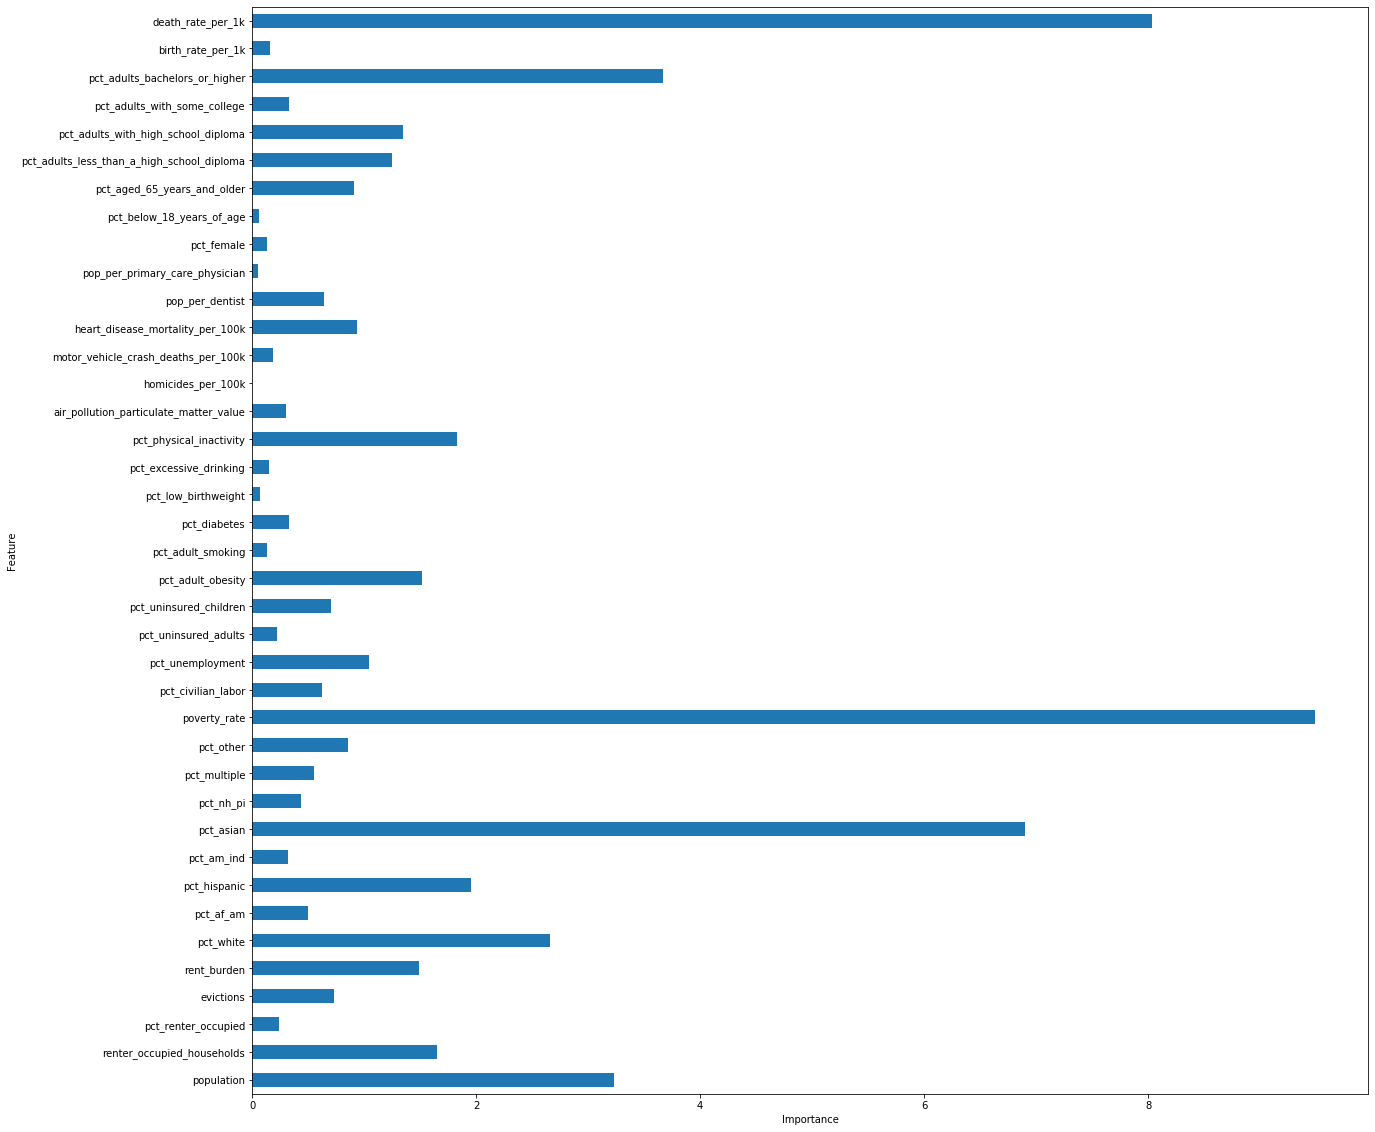

In [64]:
plt.figure(figsize=(20,20))
feat_importances = pd.Series(catreg.get_feature_importance(data=trainpool,type='LossFunctionChange'), index=X_num.columns)
feat_importances.plot(kind='barh')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

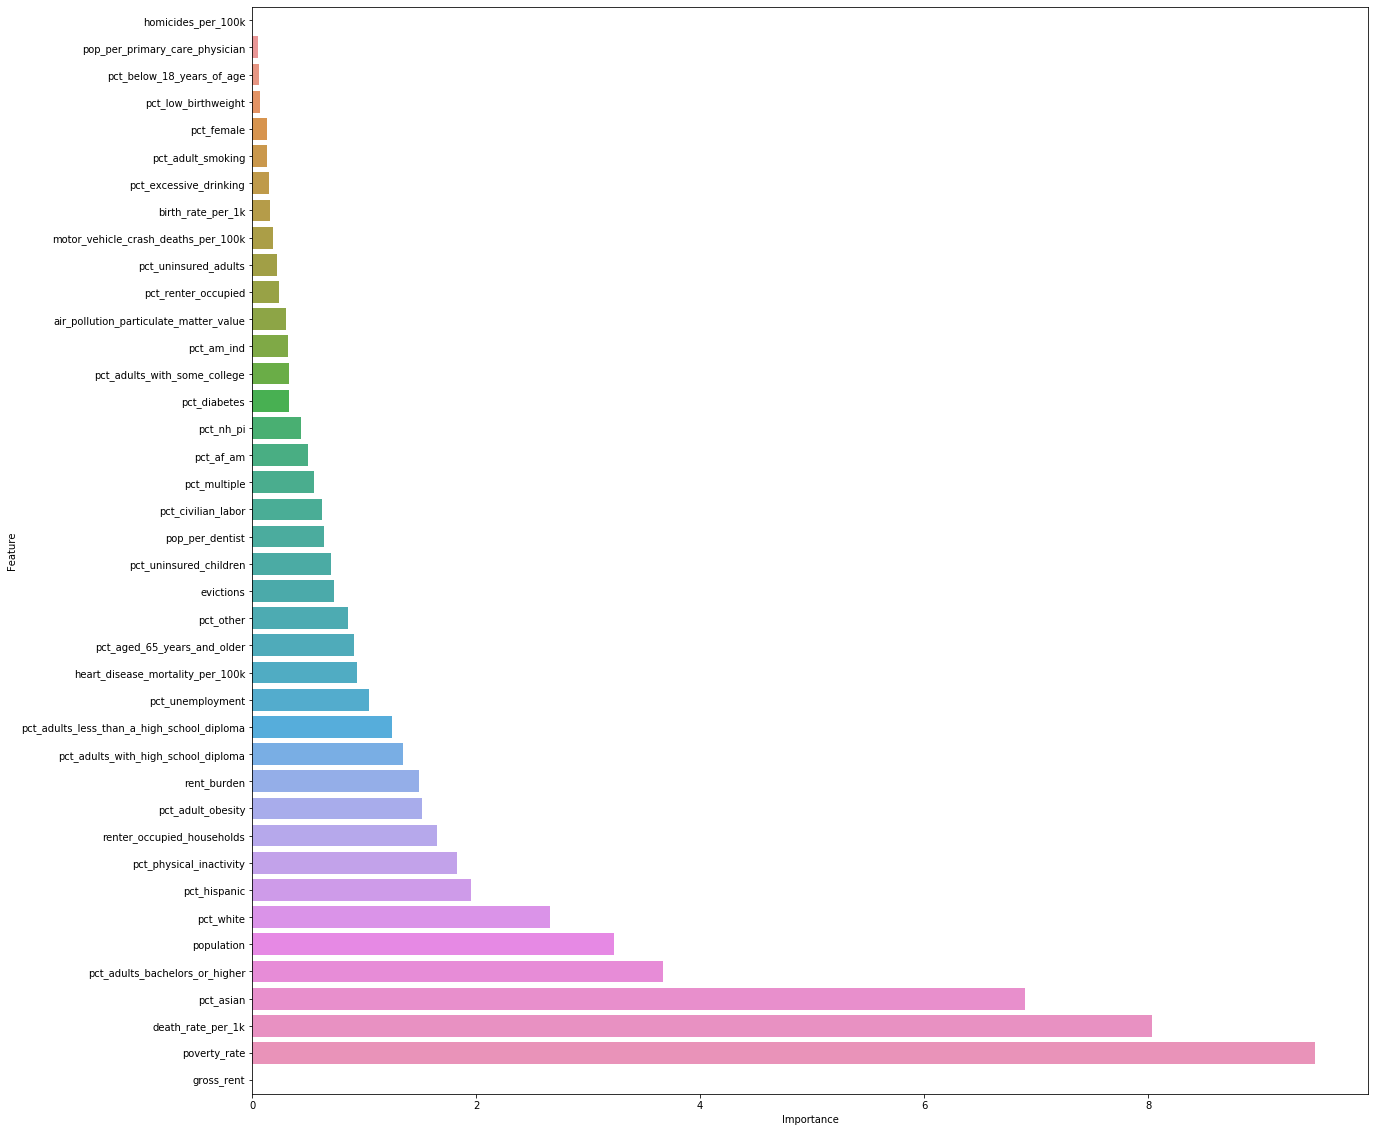

In [65]:
plt.figure(figsize=(20,20))
sns.barplot(x=combined3.LossFunction,y=combined3.Name)
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()